In [1]:
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

In [2]:
data = pd.read_csv('./data/criteo_sample.txt')

In [3]:
sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I' + str(i) for i in range(1, 14)]

In [4]:
data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )
target = ['label']

In [5]:
# Do simple Transformation for dense features
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [7]:
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,0.0,0.001332,0.092362,0.000000,0.034825,0.000000,0.000000,0.673469,0.000000,...,e5ba7672,87c6f83c,-1,-1,0429f84b,-1,3a171ecb,c0d61a5c,-1,-1
1,0,0.0,0.000000,0.006750,0.402299,0.059628,0.117284,0.003322,0.714286,0.154739,...,d4bb7bd8,6fc84bfb,-1,-1,5155d8a3,-1,be7c41b4,ded4aac9,-1,-1
2,0,0.0,0.000333,0.000710,0.137931,0.003968,0.077873,0.019934,0.714286,0.505803,...,e5ba7672,675c9258,-1,-1,2e01979f,-1,bcdee96c,6d5d1302,-1,-1
3,0,0.0,0.004664,0.000355,0.045977,0.033185,0.094967,0.016611,0.081633,0.028046,...,e5ba7672,52e44668,-1,-1,e587c466,-1,32c7478e,3b183c5c,-1,-1
4,0,0.0,0.000333,0.036945,0.310345,0.003922,0.067426,0.013289,0.653061,0.035783,...,e5ba7672,25c88e42,21ddcdc9,b1252a9d,0e8585d2,-1,32c7478e,0d4a6d1a,001f3601,92c878de


In [8]:
# Set hashing space for each sparse field, and record dense feature field name
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=1000, embedding_dim=4, use_hash=True, dtype='string')
                            # since the input is string
                            for feat in sparse_features] + [DenseFeat(feat, 1, )
                                                            for feat in dense_features]

linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns, )

In [9]:
# Generate input data for model
train, test = train_test_split(data, test_size=0.2)

train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

In [10]:
# Define Model
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy",
                metrics=['binary_crossentropy'], )

In [27]:
# Train Model
history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=50, verbose=2, validation_split=0.2, )

Epoch 1/50
1/1 - 0s - loss: 0.5357 - binary_crossentropy: 0.5357 - val_loss: 0.6802 - val_binary_crossentropy: 0.6801
Epoch 2/50
1/1 - 0s - loss: 0.5175 - binary_crossentropy: 0.5175 - val_loss: 0.6826 - val_binary_crossentropy: 0.6826
Epoch 3/50
1/1 - 0s - loss: 0.5001 - binary_crossentropy: 0.5001 - val_loss: 0.6881 - val_binary_crossentropy: 0.6881
Epoch 4/50
1/1 - 0s - loss: 0.4839 - binary_crossentropy: 0.4839 - val_loss: 0.6968 - val_binary_crossentropy: 0.6968
Epoch 5/50
1/1 - 0s - loss: 0.4688 - binary_crossentropy: 0.4688 - val_loss: 0.7077 - val_binary_crossentropy: 0.7077
Epoch 6/50
1/1 - 0s - loss: 0.4546 - binary_crossentropy: 0.4546 - val_loss: 0.7193 - val_binary_crossentropy: 0.7193
Epoch 7/50
1/1 - 0s - loss: 0.4404 - binary_crossentropy: 0.4403 - val_loss: 0.7297 - val_binary_crossentropy: 0.7297
Epoch 8/50
1/1 - 0s - loss: 0.4250 - binary_crossentropy: 0.4250 - val_loss: 0.7369 - val_binary_crossentropy: 0.7368
Epoch 9/50
1/1 - 0s - loss: 0.4075 - binary_crossentropy

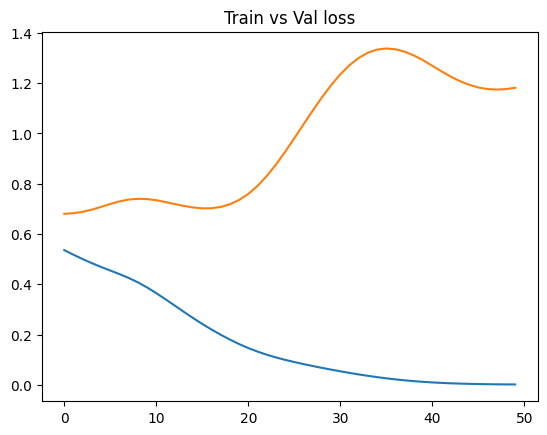

In [28]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss)
plt.plot(val_loss)

plt.title("Train vs Val loss");

In [29]:
# Predict
pred_ans = model.predict(test_model_input, batch_size=256)

In [30]:
# Evaluate Model
print("test LogLoss:", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC:", round(roc_auc_score(test[target].values, pred_ans), 4))

test LogLoss: 0.8754
test AUC: 0.5637
